# Analyses on social-spatial data and gross rent

In [2]:
import numpy as np
import collections
import pandas as pd
import pickle
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from IPython.display import GeoJSON

- a dataframe with spatial factors and gross rent but without geoinfo

In [3]:
all_df = pd.read_parquet('data_aarp_census/nj_ny_merged_with_census.parquet')

In [4]:
df = all_df[(all_df['B25058_001E'] > 0) & (all_df['total_score'] > 0)]
df = df.rename(columns={'B25058_001E': 'med_rent'})
df = df.drop(['up_mobile', 'engage_vol'], axis=1)

In [5]:
county_nj_ny = pd.read_csv('data_aarp_census/census/county_index.txt', delimiter= '\t', index_col=False, header=None, names=['state', 'county', 'county_name'], dtype=str)

In [6]:
df = df.merge(county_nj_ny, how='left', on=['state', 'county'])

- Subsets of integrated data for modeling

In [63]:
loc_rent = ['GEOID', 'state', 'county', 'tract', 'block group', 'county_name', 'med_rent']
tot_lst = ['total_score', 'engagement', 'environment', 'health', 'housing', 'opportunity', 'neighborhood', 'transportation']
demog = ['median_inc', 'life_ex', 'pct_50plus', 'pct_65plus', 'pct_africa', 'pct_asian', 'pct_disabi', 'pct_hispan', 'pct_novehi', 'pct_povert']
hs = ['house_access', 'house_burden', 'house_cost', 'house_multifam', 'house_subsidy']
eng = ['engage_broad', 'engage_civic', 'engage_culture', 'engage_social', 'engage_vote']
env = ['env_air_qual', 'env_pollute', 'env_road', 'env_water']
hlth = ['health_exercise', 'health_hospital', 'health_obese', 'health_sate', 'health_short', 'health_smoke']
ngb = ['prox_activity', 'prox_auto', 'prox_land_use', 'prox_lib', 'prox_markets', 'prox_parks', 'prox_sec', 'prox_trans', 'prox_vacant']
trns = ['trans_access', 'trans_cost', 'trans_delay', 'trans_fatal', 'trans_freq', 'trans_speed_lim', 'trans_walk_trip']
opp = ['opp_age', 'opp_grad', 'opp_income', 'opp_jobs']

In [64]:
tot_df = df[loc_rent + tot_lst]
sub_df = df[loc_rent + demog + eng + env + hlth + ngb + trns + opp]

In [45]:
sub_df.shape

(16364, 42)

- a datafram with geo info

In [7]:
# geodf = pd.read_file('data_aarp_census/nj_ny_geoid.geojson')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280800FDEB0>]],
      dtype=object)

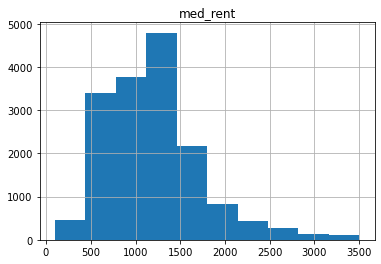

In [33]:
df.hist('med_rent')

In [22]:
df['life_ex'].value_counts()

80.0    4573
78.0    3695
82.0    2887
79.0    2737
81.0    2085
77.0     346
76.0      41
Name: life_ex, dtype: int64

In [23]:
df['up_mobile'].value_counts()

42.0    3136
47.0    2754
39.0    2398
43.0    1873
44.0    1415
45.0    1340
41.0    1095
50.0     629
40.0     560
52.0     552
46.0     464
48.0     100
51.0      48
Name: up_mobile, dtype: int64

In [47]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

In [66]:
tot_df.isnull().sum()

state             0
med_rent          0
total_score       0
engagement        0
environment       0
health            0
housing           0
neighborhood      0
opportunity       0
transportation    0
dtype: int64

In [68]:
tot_df.shape

(16364, 10)

## Prediction Models

In [9]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

### 1. Linear regression for predictior group 1: overall livability ratings

I observed some plausible linear trends from above pairplots. Therefore the first testing model could be a linear regression when using overall livability socres containing six aspects to predict rental prices.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
loc_rent + ['total_score']

['GEOID',
 'state',
 'county',
 'tract',
 'block group',
 'county_name',
 'med_rent',
 'total_score']

In [55]:
# create subset: overall livability
y = tot_df['med_rent']
X = tot_df.drop(loc_rent + ['total_score'], axis=1)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)         
X_trans = scaler.transform(X)  

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.3, random_state=101)

In [54]:
lm = LinearRegression()

In [55]:
lm.fit(X_train, y_train)
print(f'Coefficient:\n{lm.coef_}')

Coefficient:
[ -0.80042269  -1.78082446  -1.28724158  10.68944532 -18.03894556
   7.5845363   -4.32643942   1.55651059]


- Evaluate the model

In [74]:
predictions_trn = lm.predict(X_train)
r2_score(y_train, predictions_trn, multioutput='variance_weighted')

0.5860175894461843

In [16]:
# from sklearn import metrics

# print('MAE:', metrics.mean_absolute_error(y_test, predictions))
# print('MSE:', metrics.mean_squared_error(y_test, predictions))
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [76]:
predictions_tst = lm.predict(X_test)
r2_score(y_test, predictions_tst, multioutput='variance_weighted')

0.5833009995270523

[Text(0, 0.5, 'Predicted rents'), Text(0.5, 0, 'True rents')]

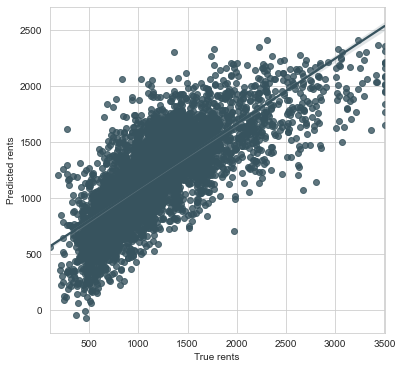

In [77]:
fig = sns.regplot(x=y_test, y = predictions_tst)
fig.set(xlabel = 'True rents', ylabel= 'Predicted rents')

The results from linear regression had a high bias with a low R-square.

- Correlations between overall livability scores and average rents

In [78]:
import statsmodels.api as sm
from scipy import stats

In [79]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               med_rent   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     3299.
Date:                Mon, 12 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:10:40   Log-Likelihood:            -1.1883e+05
No. Observations:               16364   AIC:                         2.377e+05
Df Residuals:                   16356   BIC:                         2.377e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1324.5448     32.082     41.

### 2. Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

#### Model 1: Random Forest with total scores

In [ ]:
# Model-1: using livability overall scores for prediction
y = tot_df['med_rent']
X = tot_df.drop(loc_rent + ['total_score'], axis=1)

In [13]:
scaler = StandardScaler()
scaler.fit(X)         
X_trans = scaler.transform(X)  

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.30, random_state=42)

In [17]:
rfr = RandomForestRegressor(n_estimators=500, max_depth=10)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=500)

- Hyperparameter selections

In [16]:
print("The best hyperparameter value is: ", gs.best_params_)

The best hyperparameter value is:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}


- Establish a baseline

In [18]:
baseline_preds = y_train.mean()

In [19]:
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline mean absolute error: ', round(np.mean(baseline_errors), 2))

Average baseline mean absolute error:  404.33


- Model evaluation with full features

In [20]:
predictions = rfr.predict(X_test)

In [22]:
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rfr.score(X_train, y_train), 
                                                                                             rfr.score(X_test, y_test)))

R^2 Training Score: 0.78 
R^2 Validation Score: 0.64


- Using the baseline error (404.33) to evaluate the erros from predictions

In [23]:
errors = abs(predictions - y_test)
print('Random Forest (full) - Mean Absolute Error:', round(np.mean(errors), 2))

# print("Mean absolute error:", metrics.mean_absolute_error(y_test, predictions))
print("Mean squared error:", metrics.mean_squared_error(y_test, predictions))
print("R^2:", metrics.r2_score(y_test, predictions))

Random Forest (full) - Mean Absolute Error: 222.66
Mean squared error: 101748.01061644804
R^2: 0.6448602023164473


- Determine Performance Metrics
To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [24]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Random Forest (full) - Accuracy:', round(accuracy, 2), '%.')

Random Forest (full) - Accuracy: 79.12 %.


- Identify important features

In [25]:
# print out the importance of each category
importances = rfr.feature_importances_
# print([rfr.feature_importances_] + [X.columns])

In [26]:
imp = pd.DataFrame({'Variable':X.columns,
                    'Importance':rfr.feature_importances_}).sort_values('Importance', ascending=False)
imp.head(10)

,Variable,Importance
4,housing,0.524976
3,health,0.181990
5,neighborhood,0.129258
6,opportunity,0.048069
7,transportation,0.037594
1,engagement,0.028434
2,environment,0.027820
0,total_score,0.021860


In [99]:
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [36]:
# # print the feature list
# feature_list = list(X.columns)
# # pd.DataFrame(feature_list)

In [98]:
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

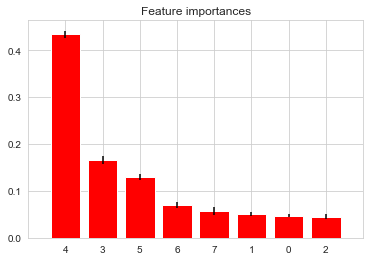

In [100]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Model 2: Random Forest with detailed scores

In [150]:
# Model-1: using livability overall scores for prediction
y = sub_df['med_rent']
X = sub_df.drop(loc_rent, axis=1)

In [69]:
# scaler = StandardScaler()
# scaler.fit(X)         
# X_trans = scaler.transform(X)  

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [67]:
rfr = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=2)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=500)

In [33]:
print("The best hyperparameter value is: ", gs.best_params_)

The best hyperparameter value is:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}


- Establish a baseline

In [68]:
baseline_preds = y_train.mean()

In [69]:
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline mean absolute error: ', round(np.mean(baseline_errors), 2))

Average baseline mean absolute error:  404.33


- Model evaluation with full features

In [70]:
predictions = rfr.predict(X_test)

In [71]:
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rfr.score(X_train, y_train), 
                                                                         rfr.score(X_test, y_test)))

R^2 Training Score: 0.83 
R^2 Validation Score: 0.66


- Using the baseline error (404.33) to evaluate the erros from predictions

In [72]:
errors = abs(predictions - y_test)
print('Random Forest (full) - Mean Absolute Error:', round(np.mean(errors), 2))

# print("Mean absolute error:", metrics.mean_absolute_error(y_test, predictions))
print("Mean squared error:", metrics.mean_squared_error(y_test, predictions))
print("R^2:", metrics.r2_score(y_test, predictions))

Random Forest (full) - Mean Absolute Error: 211.87
Mean squared error: 96322.84223943853
R^2: 0.6637961322490067


- Determine Performance Metrics
To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [73]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Random Forest (full) - Accuracy:', round(accuracy, 2), '%.')

Random Forest (full) - Accuracy: 79.28 %.


- Identify important features

In [74]:
# print out the importance of each category
importances = rfr.feature_importances_
# print([rfr.feature_importances_] + [X.columns])

In [85]:
imp = pd.DataFrame({'Variable':X.columns,
                    'Importance':rfr.feature_importances_}).sort_values('Importance', ascending=False)
imp['Rank'] = range(1, len(X.columns)+1)

In [105]:
mnp_lst = ['engage_broad',
           'env_air_qual', 'env_pollute', 'env_road', 'env_water',
           'health_exercise', 'health_sate', 'health_short',
           'prox_activity', 'prox_auto', 'prox_land_use', 'prox_lib', 'prox_markets', 'prox_parks', 'prox_sec', 'prox_trans', 'prox_vacant',
           'trans_access', 'trans_fatal', 'trans_freq', 'trans_speed_lim', 'trans_walk_trip']

In [106]:
top_20 = imp[:20]
top_20[top_20['Variable'].isin(mnp_lst)]

,Variable,Importance,Rank
32,prox_trans,0.040452,5
26,prox_auto,0.013160,7
37,trans_fatal,0.009756,13
29,prox_markets,0.007809,16
40,trans_walk_trip,0.007408,19
27,prox_land_use,0.007298,20


In [61]:
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

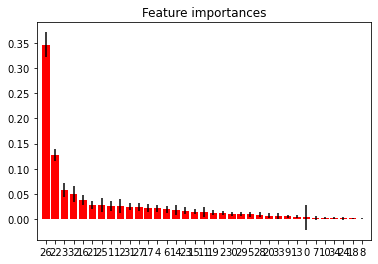

In [62]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
import statsmodels.api as sm
from scipy import stats

In [27]:
# scaler = StandardScaler()
# scaler.fit(X)         
# X_trans = scaler.transform(X)  

- **Top Influential factors**

**health_obese**: percentage of people are obese

**median_inc**

**engage_civic**: nubmer of organizations per 10,000 people, negative

**health_smoke**: percentage of people smoke regularly

- **Influential factors that can be manipulated**

-- **prox_trans** (jobs, us median = 0) -- rank 5

Number of jobs accessible within a 45-minute transit commute: measured at the neighborhood scale, higher values are better

Thousands of commuters use buses, trains, and subways each day to get to work. For these workers, convenient and dependable transit isn’t just a perk—it’s a necessity. Good public transportation generally costs less than driving and parking, encourages more walking, and reduces air pollution. Here, the Index measures the number of jobs accessible within a 45-minute commute by transit, giving more credit to nearby jobs than those farther away. Note: Data are available only for areas where transit agencies provide information to an online mapping database.

-- **prox_auto** (jobs, us median = 32,699) -- rank 7

Number of jobs accessible within a 45-minute automobile commute: measured at the neighborhood scale, higher values are better	

Many of our metrics look at healthy, affordable transportation options like public transit, walking, and bicycling—but what about people who depend on their cars to get around? Most Americans drive to work, and most prefer a shorter commute. In this case, we examine how well neighborhoods allow people to access jobs. Better accessibility means less time sitting in the car, less money spent on gas and maintenance, and more time with friends and family. The Index measures the number of jobs that are accessible within a 45-minute drive


-- **trans_fatal** (fatal crashes per 100,000 people per year, us median = 6.8) -- rank 13

Annual average number of fatal crashes per 100,000 people: measured at the neighborhood scale, lower values are better

Motor vehicle crashes are a leading cause of death in the United States. Crashes occur most often in areas with high speed limits, poorly designed streets, and in places where people must drive farther or more frequently to reach their destinations. Bicyclists and pedestrians are particularly vulnerable to crashes, as are children and older adults. Since people typically drive outside their neighborhood, the Index measures the number of fatal crashes within a 5-mile radius to assess safety on the surrounding streets. Fatal crashes are relatively rare in any given neighborhood, so we use a 5-year average to control for year-to-year changes.

-- **prox_markets** (stores and markets, us median = 0)b -- rank 16

Number of grocery stores and farmers’ markets within a half-mile: measured at the neighborhood scale, higher values are better

It’s hard to make healthy food choices if grocery stores and farmers’ markets aren’t nearby. People living in low-income households and individuals who don’t drive are more likely to rely on nearby food sources—and may end up paying more if their only grocery option is a convenience store. Farmers’ markets can also serve as important community gathering places. The Index gives higher scores to communities that provide a wide variety of healthy food options within walking distance.


-- **trans_walk_trip** (trips per household per day, us median = 0.73) -- rank 19

Estimated walk trips per household per day: measured at the neighborhood scale, higher values are better

Physical activity contributes to health and longevity. Making trips around the neighborhood by walking (called “walk trips”) can be a safe form of exercise. Walk trips also contribute to more frequent social interaction with neighbors. The Index estimates the number of walk trips members of an average household take each day. It includes factors such as the number of destinations within a mile and how easy it is to navigate local streets. The goal is to measure how walkable the neighborhoods are.


-- **prox_land_use** (index from 0 to 1, us median = 0.7) -- rank 20

Mix of jobs within a mile: measured at the neighborhood scale, higher values are better

The mix of jobs within a mile reflects the likelihood that a variety of destinations and services are available within the neighborhood. Livable neighborhoods make it easy for residents to walk to a diverse range of destinations and services, including shopping, entertainment, health care, and more. The Index measures how well a neighborhood offers convenient access to retail, entertainment, health care, education, and food or personal services. Measured on a scale from 0 to 1, higher values are given to communities that offer better access.

- **If change health_obese cores, how rent changes along with it?**

In [180]:
# train the model
y = sub_df['med_rent']
X = sub_df.drop(loc_rent, axis=1)

rfr = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=2)
rfr.fit(X,y)

y_pred = rfr.predict(X)

In [198]:
def change_factors(var_lst, degree_lst, y, X, y_pred):
    Y_dict = {}
    Y_dict['y_real'] = y.to_numpy()
    Y_dict['y_pred'] = y_pred
    
    for var in var_lst:
        for degree in degree_lst:    
            X_new = X.copy()
            X_new[var] = X_new[var] * degree
            y_new = rfr.predict(X_new)
            Y_dict[f'{var}_{degree}'] = y_new
            
    return pd.DataFrame(Y_dict)

In [199]:
kf = ['prox_trans', 'prox_auto', 'prox_markets', 'trans_walk_trip', 'prox_land_use']
change_degree = np.arange(2, 12, 2)

In [200]:
df_Y = change_factors(kf, change_degree, y, X, y_pred)

In [201]:
rent_pred = pd.concat([df, df_Y], axis = 1)

In [202]:
rent_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16364 entries, 0 to 16363
Data columns (total 93 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_popu          16364 non-null  float64
 1   pct_africa          16364 non-null  float64
 2   pct_asian           16364 non-null  float64
 3   pct_hispan          16364 non-null  float64
 4   pct_50plus          16364 non-null  float64
 5   pct_65plus          16364 non-null  float64
 6   median_inc          16364 non-null  float64
 7   pct_povert          16364 non-null  float64
 8   pct_disabi          16364 non-null  float64
 9   pct_novehi          16364 non-null  float64
 10  life_ex             16364 non-null  float64
 11  engagement          16364 non-null  float64
 12  environment         16364 non-null  float64
 13  health              16364 non-null  float64
 14  housing             16364 non-null  float64
 15  neighborhood        16364 non-null  float64
 16  oppo

In [203]:
df_Y.describe()

,y_real,y_pred,prox_trans_2,prox_trans_4,prox_trans_6,prox_trans_8,prox_trans_10,prox_auto_2,prox_auto_4,prox_auto_6,...,trans_walk_trip_2,trans_walk_trip_4,trans_walk_trip_6,trans_walk_trip_8,trans_walk_trip_10,prox_land_use_2,prox_land_use_4,prox_land_use_6,prox_land_use_8,prox_land_use_10
count,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,...,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000,16364.000000
mean,1196.885419,1196.716285,1211.874739,1231.523479,1243.998198,1253.503686,1260.394025,1212.248156,1226.195362,1232.288876,...,1201.363026,1205.817539,1209.934779,1212.555206,1214.278899,1207.201154,1207.943077,1208.018960,1208.044579,1208.080885
std,535.238903,443.298574,455.602206,468.270964,475.984266,481.590511,485.664468,452.882563,458.052717,459.274318,...,444.158600,445.635537,446.829284,447.180553,447.192157,440.629425,440.132500,440.123973,440.105444,440.078345
min,99.000000,361.248839,370.626458,371.747391,371.747391,371.747391,371.747391,362.653175,368.301897,368.301897,...,394.438884,417.374180,417.374180,417.374180,417.374180,361.248839,361.248839,361.248839,361.248839,361.248839
25%,804.000000,851.880846,854.105474,857.165305,859.153672,859.976966,860.077949,865.961574,874.682794,876.140946,...,859.292199,863.296723,864.753047,865.984979,866.859829,881.105184,882.691701,883.001929,883.001929,883.091132
50%,1153.000000,1218.117576,1225.863788,1235.962973,1244.402468,1251.001268,1255.343659,1229.035292,1248.345552,1261.346031,...,1220.339521,1223.428826,1230.852230,1241.253739,1248.074554,1227.827306,1228.681400,1228.681400,1228.681400,1228.681400
75%,1443.000000,1416.275125,1454.306692,1506.125144,1538.866996,1567.070658,1588.503558,1433.636588,1470.280565,1495.352612,...,1418.650059,1424.570771,1430.726397,1434.637151,1437.989436,1432.000487,1432.670728,1432.670728,1432.670728,1432.670728
max,3501.000000,3308.210172,3306.125553,3306.125553,3306.125553,3306.125553,3306.125553,3274.001547,3274.001547,3274.001547,...,3308.210172,3308.210172,3308.210172,3308.210172,3308.210172,3220.436719,3220.436719,3220.436719,3220.436719,3220.436719


In [204]:
rent_pred.to_pickle("./all_data.pkl")